# Autor: Alexej Kravtschenko (100 %)

- **Preface:** This was my initial attempt to implement an autoencoder, which was later discarded as I was dissatisfied with the results and couldn't further improve them.
- **Dataset:** The UNSW_NB15_training-set dataset was used. This dataset does not contain timestamps.
- **Preprocessing:** Only the best features were extracted, which were then divided into normal and anomalous data.
- **Conclusion:** It is incomplete and mostly uncommented. Therefore, I do not expect any evaluation on it. However, I am satisfied with the initial result achieved through my preprocessing.

# 0. Imports 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras import layers
from keras.models import Model

# 1. Exploratory data analysis - EDA


## 1.1 Overview of the data

In [ ]:
from zipfile import ZipFile 

# Extract the dataset form /data
with ZipFile("data/UNSW_NB15.zip" , 'r') as zObject: 
    zObject.extractall(path="data/") 
zObject.close() 

In [2]:
dataframe = pd.read_csv('./data/UNSW_NB15_training-set.csv')
dataframe.head(10)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.09020,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.00030,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.00510,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.66080,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.00250,...,1,3,0,0,0,2,3,0,Normal,0
5,6,0.000003,udp,-,INT,2,0,784,0,333333.32150,...,1,2,0,0,0,2,2,0,Normal,0
6,7,0.000006,udp,-,INT,2,0,1960,0,166666.66080,...,1,2,0,0,0,2,2,0,Normal,0
7,8,0.000028,udp,-,INT,2,0,1384,0,35714.28522,...,1,3,0,0,0,1,3,0,Normal,0
8,9,0.000000,arp,-,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0
9,10,0.000000,arp,-,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0


In [ ]:
dataframe.shape

In [ ]:
dataframe.info()

In [3]:
dataframe.drop(dataframe.columns[dataframe.columns.str.contains('id', case=False)], axis=1, inplace=True)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dur                82332 non-null  float64
 1   proto              82332 non-null  object 
 2   service            82332 non-null  object 
 3   state              82332 non-null  object 
 4   spkts              82332 non-null  int64  
 5   dpkts              82332 non-null  int64  
 6   sbytes             82332 non-null  int64  
 7   dbytes             82332 non-null  int64  
 8   rate               82332 non-null  float64
 9   sttl               82332 non-null  int64  
 10  dttl               82332 non-null  int64  
 11  sload              82332 non-null  float64
 12  dload              82332 non-null  float64
 13  sloss              82332 non-null  int64  
 14  dloss              82332 non-null  int64  
 15  sinpkt             82332 non-null  float64
 16  dinpkt             823

In [ ]:
# Überprüfen Sie auf gemischte Typen in den Spalten
mixed_types = dataframe.apply(lambda x: any(isinstance(val, str) for val in x))

# Zeigen Sie die gemischten Typen und ihre Werte an
print("Gemischte Typen in den Spalten:")
for column, is_mixed_type in mixed_types.items():
    if is_mixed_type:
        mixed_values = dataframe.loc[dataframe[column].apply(lambda x: isinstance(x, str)), column].unique()
        print(f"Spalte {column} enthält gemischte Typen mit den Werten: {mixed_values}")

In [ ]:
sns.histplot(x = dataframe.label)

## 1.2 Nummeric feature analysis

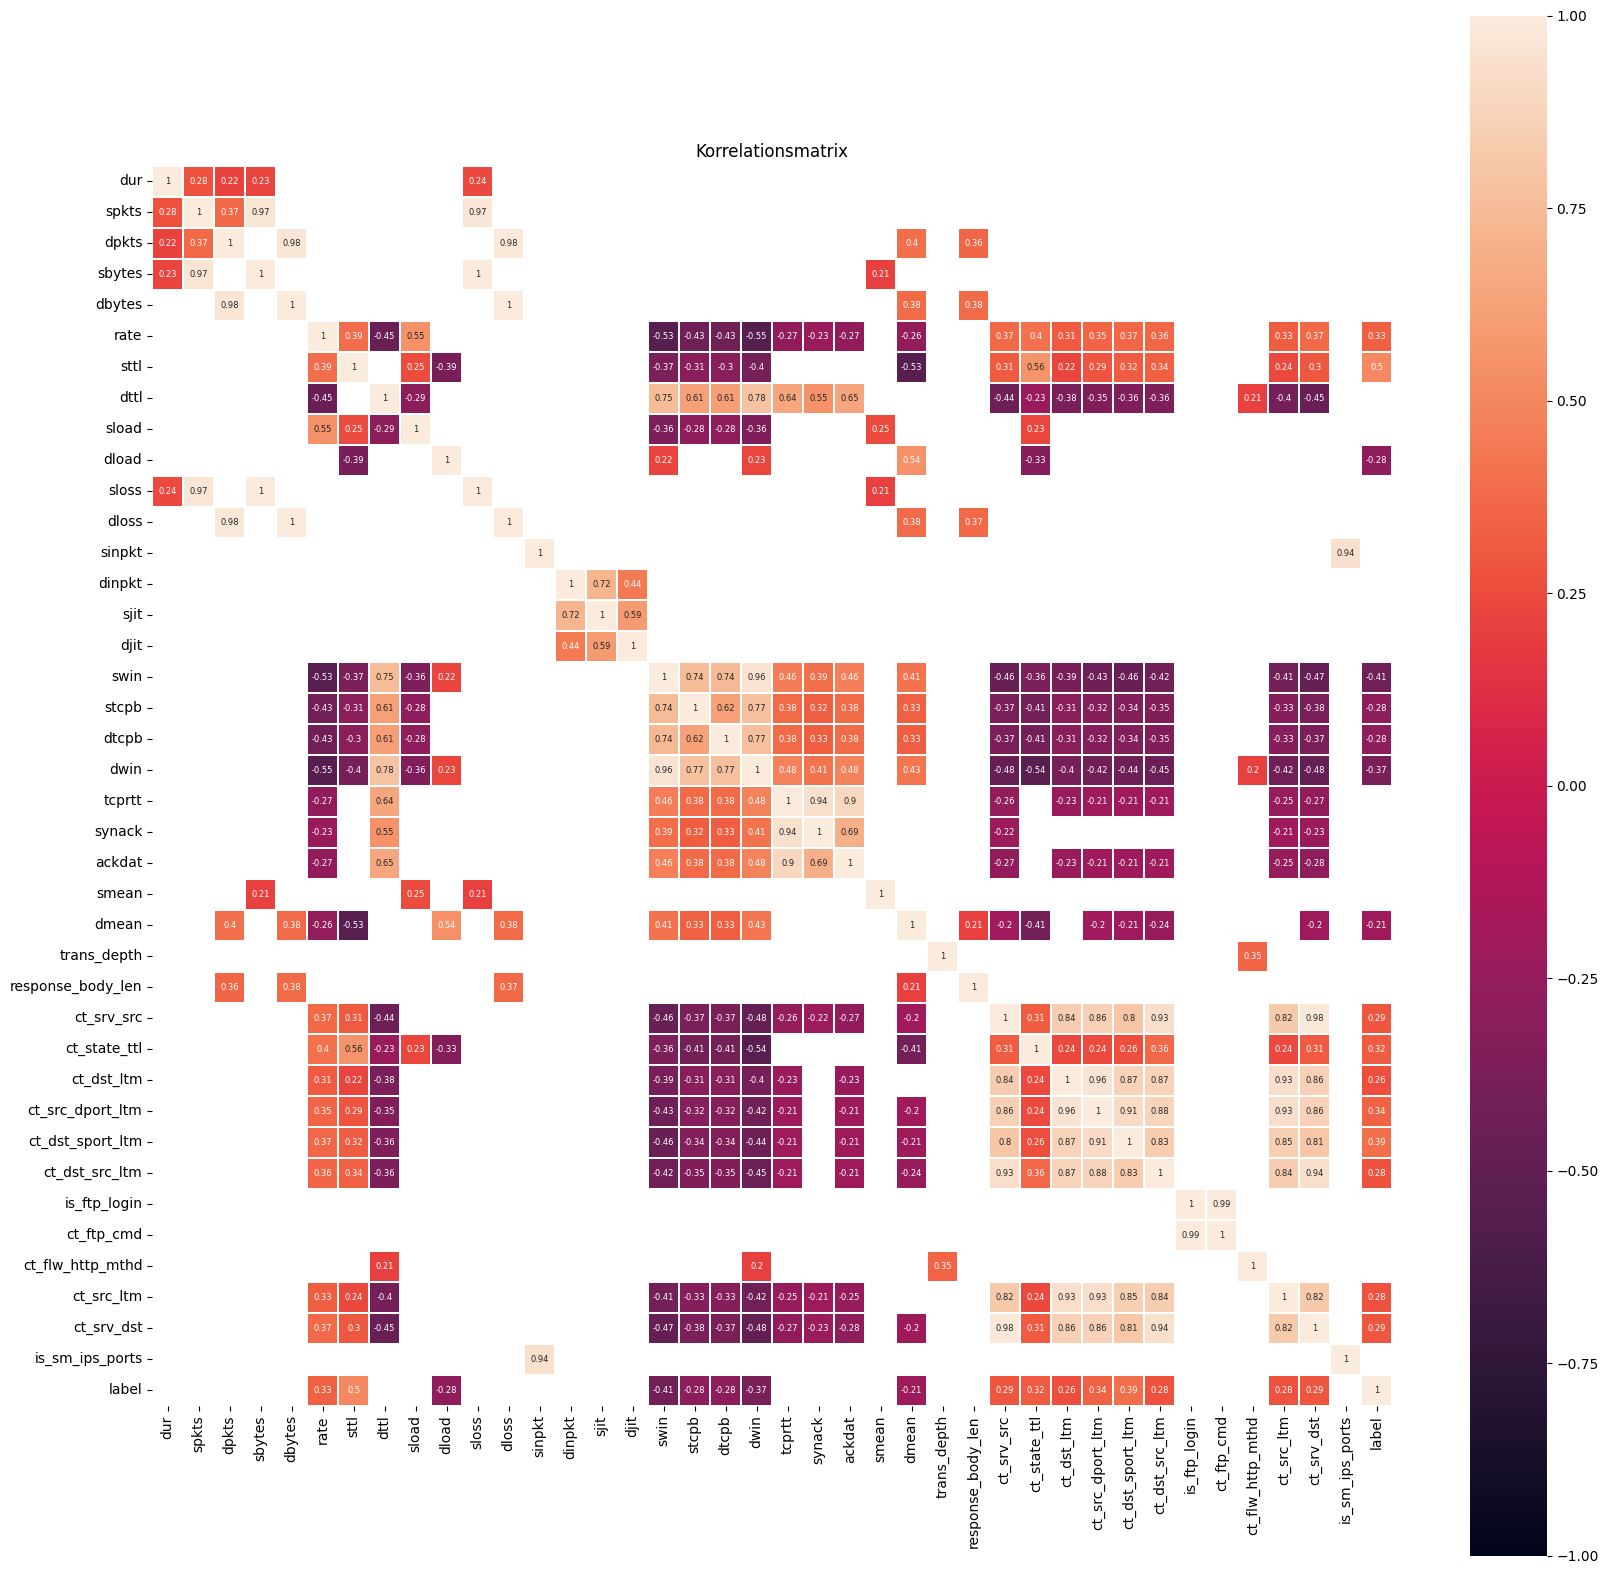

In [4]:
nummerisch = dataframe.select_dtypes(include=['float64', 'int64', 'int16', 'int32'])
corr_matrix = nummerisch.corr()
plt.figure(figsize=(20, 20))

sns.heatmap(corr_matrix[(corr_matrix >= 0.2) | (corr_matrix <= -0.2)], vmax=1.0, 
            vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 6}, square=True)
plt.title('Korrelationsmatrix')
plt.show()

In [5]:
df_num_corr = dataframe.corr(numeric_only=True)['label']
df_num_corr = df_num_corr[df_num_corr >= -1]
print(df_num_corr)

dur                 -0.001145
spkts               -0.027731
dpkts               -0.061515
sbytes               0.020641
dbytes              -0.032632
rate                 0.328629
sttl                 0.504159
dttl                -0.098591
sload                0.124548
dload               -0.280534
sloss                0.006360
dloss               -0.044399
sinpkt              -0.120768
dinpkt              -0.037585
sjit                -0.027397
djit                -0.027131
swin                -0.414504
stcpb               -0.281428
dtcpb               -0.282860
dwin                -0.369257
tcprtt              -0.148800
synack              -0.149944
ackdat              -0.120522
smean               -0.061146
dmean               -0.211544
trans_depth         -0.025804
response_body_len   -0.016414
ct_srv_src           0.290195
ct_state_ttl         0.318517
ct_dst_ltm           0.257995
ct_src_dport_ltm     0.341513
ct_dst_sport_ltm     0.393668
ct_dst_src_ltm       0.279989
is_ftp_log

In [6]:
golden_features_list = df_num_corr[abs(df_num_corr) > abs(0.2)].sort_values(ascending=False)
print("There are {} strongly correlated values with Target:\n{}".format(len(golden_features_list), golden_features_list))

There are 17 strongly correlated values with Target:
label               1.000000
sttl                0.504159
ct_dst_sport_ltm    0.393668
ct_src_dport_ltm    0.341513
rate                0.328629
ct_state_ttl        0.318517
ct_srv_dst          0.292931
ct_srv_src          0.290195
ct_dst_src_ltm      0.279989
ct_src_ltm          0.276494
ct_dst_ltm          0.257995
dmean              -0.211544
dload              -0.280534
stcpb              -0.281428
dtcpb              -0.282860
dwin               -0.369257
swin               -0.414504
Name: label, dtype: float64


## 1.3 Object feature analysis

In [7]:
df_not_num = dataframe.select_dtypes(include = ['O'])
print('There is {} non numerical features including:\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))

There is 4 non numerical features including:
['proto', 'service', 'state', 'attack_cat']


In [8]:
dtypes = dataframe.dtypes
categorical_features = dtypes[dtypes == 'object'].index.tolist()

In [ ]:
for feature in df_not_num:
        sns.boxplot(x=feature, y='label', data=dataframe)
        plt.xticks(rotation=90)  
        plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, feature in enumerate(df_not_num):
    row = i // 2  
    col = i % 2   
    sns.boxplot(x=feature, y='label', data=dataframe, ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot für {feature}')
    axes[row, col].tick_params(axis='x', rotation=90)  
    
plt.tight_layout()
plt.show()

In [34]:
dataframe.drop(dataframe.columns[dataframe.columns.str.contains('attack_cat', case=False)], axis=1, inplace=True)
# dataframe.drop(dataframe.columns[dataframe.columns.str.contains('proto', case=False)], axis=1, inplace=True)
# dataframe.drop(dataframe.columns[dataframe.columns.str.contains('state', case=False)], axis=1, inplace=True)
# dataframe.drop(dataframe.columns[dataframe.columns.str.contains('service', case=False)], axis=1, inplace=True)
# dataframe.info()

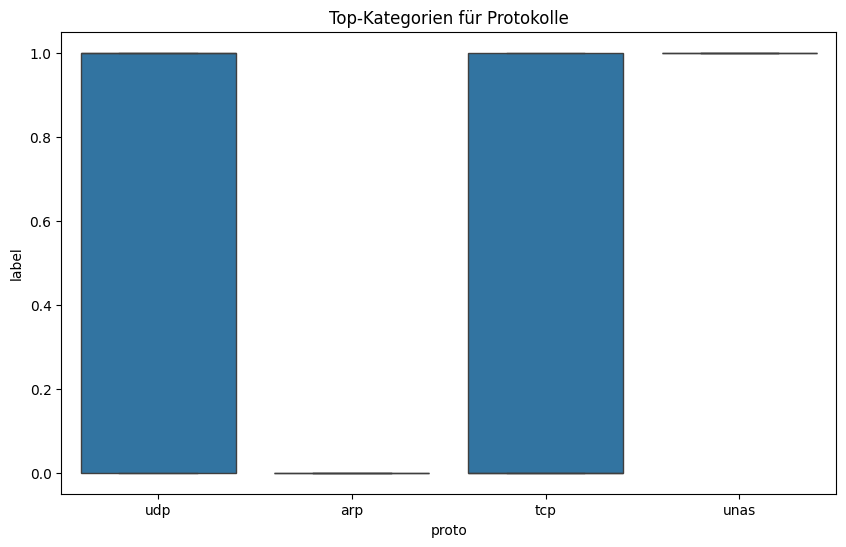

In [35]:
num_categories_to_display = 4

top_categories = dataframe['proto'].value_counts().nlargest(num_categories_to_display).index
df_filtered = dataframe[dataframe['proto'].isin(top_categories)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='proto', y='label', data=df_filtered)
plt.title('Top-Kategorien für Protokolle')
#plt.xticks(rotation=90)  
plt.show()

In [ ]:
pd.crosstab(index=dataframe['proto'], columns=dataframe['proto'])

## 1.4 Feature extraction

In [36]:
dtypes = dataframe.dtypes
categorical_features = dtypes[dtypes == 'object'].index.tolist()

In [37]:
nummerical_features = golden_features_list.index.tolist()

df_selected_features = dataframe[nummerical_features + categorical_features]

df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   label             82332 non-null  int64  
 1   sttl              82332 non-null  int64  
 2   ct_dst_sport_ltm  82332 non-null  int64  
 3   ct_src_dport_ltm  82332 non-null  int64  
 4   rate              82332 non-null  float64
 5   ct_state_ttl      82332 non-null  int64  
 6   ct_srv_dst        82332 non-null  int64  
 7   ct_srv_src        82332 non-null  int64  
 8   ct_dst_src_ltm    82332 non-null  int64  
 9   ct_src_ltm        82332 non-null  int64  
 10  ct_dst_ltm        82332 non-null  int64  
 11  dmean             82332 non-null  int64  
 12  dload             82332 non-null  float64
 13  stcpb             82332 non-null  int64  
 14  dtcpb             82332 non-null  int64  
 15  dwin              82332 non-null  int64  
 16  swin              82332 non-null  int64 

In [38]:
values_to_encode_proto      = ['tcp', 'udp', 'arp']
values_to_encode_service    = ['-', 'http', 'ftp', 'ftp-data', 'smtp']
values_to_encode_state      = ['FIN', 'ACC']

selected_rows_proto = df_selected_features[df_selected_features['proto'].isin(values_to_encode_proto)]


# dType: Object to float64
encoded_dataframe = pd.get_dummies(selected_rows_proto, columns=['proto'], prefix=["proto"], dtype=float)
selected_rows_service = encoded_dataframe[encoded_dataframe['service'].isin(values_to_encode_service)]

encoded_dataframe = pd.get_dummies(selected_rows_service, columns=['service'], prefix=["service"], dtype=float)
selected_rows_state = encoded_dataframe[encoded_dataframe['state'].isin(values_to_encode_state)]

encoded_dataframe = pd.get_dummies(selected_rows_state, columns=['state'], prefix=["state"], dtype=float)

encoded_dataframe.sample(3)

,label,sttl,ct_dst_sport_ltm,ct_src_dport_ltm,rate,ct_state_ttl,ct_srv_dst,ct_srv_src,ct_dst_src_ltm,ct_src_ltm,...,proto_arp,proto_tcp,proto_udp,service_-,service_ftp,service_ftp-data,service_http,service_smtp,state_ACC,state_FIN
78570,0,254,1,2,14.698152,1,9,10,5,2,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
24793,0,31,1,1,121.971055,0,6,6,3,5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
44318,1,62,1,1,81.566417,1,1,1,1,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## 1.5 Finished dataextraction overview

In [39]:
encoded_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38670 entries, 29 to 82328
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   label             38670 non-null  int64  
 1   sttl              38670 non-null  int64  
 2   ct_dst_sport_ltm  38670 non-null  int64  
 3   ct_src_dport_ltm  38670 non-null  int64  
 4   rate              38670 non-null  float64
 5   ct_state_ttl      38670 non-null  int64  
 6   ct_srv_dst        38670 non-null  int64  
 7   ct_srv_src        38670 non-null  int64  
 8   ct_dst_src_ltm    38670 non-null  int64  
 9   ct_src_ltm        38670 non-null  int64  
 10  ct_dst_ltm        38670 non-null  int64  
 11  dmean             38670 non-null  int64  
 12  dload             38670 non-null  float64
 13  stcpb             38670 non-null  int64  
 14  dtcpb             38670 non-null  int64  
 15  dwin              38670 non-null  int64  
 16  swin              38670 non-null  int64  
 1

# Classification

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import tree

In [ ]:
encoded_dataframe.info()

In [ ]:
class_df = encoded_dataframe

X = class_df.drop('label', axis=1)
y = class_df['label']

scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [ ]:
plt.grid()
plt.plot(np.arange(26), X_normalized[0])
plt.title("Normalized Plot")
plt.show()

In [ ]:
# Zu optimierende Parameter
parameters = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 5, 8, 12],
    'min_samples_leaf': [1, 3, 5, 7, 15], 
}

# Verwende Grid Search, um die beste Parameterkombination zu finden
grid_search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5)
grid_search.fit(X, y)
best_params = grid_search.best_params_

clf_dt = DecisionTreeClassifier(**best_params)
clf_dt.fit(X_train, y_train)

In [ ]:
# Verwende die festgelegten Hyperparameter
clf_svm = SVC(C=1000, kernel='rbf')

clf_svm.fit(X_train, y_train)

In [ ]:
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 12, 14]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X, y)
best_params = grid_search.best_params_

# Verwende den besten Wert für n_neighbors
clf_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
clf_knn.fit(X_train, y_train)

In [ ]:
cv_scores_dt = cross_val_score(clf_dt, X, y, cv=5)  # cv ist die Anzahl der Folds (hier: 5)

for fold, accuracy in enumerate(cv_scores_dt):
    print(f"Genauigkeit Fold {fold+1}: {accuracy}")

# Berechne und gib den Durchschnitt der Genauigkeiten aus
average_accuracy_dt = cv_scores_dt.mean()
print(f"Durchschnittliche Entscheidungsbaum Genauigkeit: {average_accuracy_dt}")

In [ ]:
cv_scores_knn = cross_val_score(clf_knn, X, y, cv=5)  # cv ist die Anzahl der Folds (hier: 5)

for fold, accuracy in enumerate(cv_scores_knn):
    print(f"Genauigkeit Fold {fold+1}: {accuracy}")

# Berechne und gib den Durchschnitt der Genauigkeiten aus
average_accuracy_knn = cv_scores_knn.mean()
print(f"Durchschnittliche KNN Genauigkeit: {average_accuracy_knn}")

In [ ]:
cv_scores_svm = cross_val_score(clf_svm, X, y, cv=2)  # cv ist die Anzahl der Folds (hier: 2)

for fold, accuracy in enumerate(cv_scores_svm):
    print(f"Genauigkeit Fold {fold+1}: {accuracy}")

# Berechne und gib den Durchschnitt der Genauigkeiten aus
average_accuracy_svm = cv_scores_svm.mean()
print(f"Durchschnittliche Stützvektormaschinen Genauigkeit: {average_accuracy_svm}")

In [ ]:
# Vorhersagen auf dem Testdatensatz machen
y_pred_dt = clf_dt.predict(X_test)
y_pred_svm = clf_svm.predict(X_test)
y_pred_knn = clf_knn.predict(X_test)

accuracy_dt = metrics.accuracy_score(y_test, y_pred_dt)
accuracy_svm = metrics.accuracy_score(y_test, y_pred_svm)
accuracy_knn = metrics.accuracy_score(y_test, y_pred_knn)

print("Accuracy (Decision Tree):", accuracy_dt)
print("Accuracy (Support Vector Machine):", accuracy_svm)
print("Accuracy (k-Nearest Neighbors):", accuracy_knn)

In [ ]:
print("Entscheidungsbaum:\n",classification_report(y_test, y_pred_dt))
print("Stützvektormaschine:\n",classification_report(y_test, y_pred_svm))
print("k-Nearest Neighbors:\n",classification_report(y_test, y_pred_knn))

In [ ]:
# Plot des Entscheidungsbaums
plt.figure(figsize=(10, 10))
tree.plot_tree(clf_dt, filled=True, feature_names=X.columns, class_names=['Normal', 'Anomaly'], fontsize=10, max_depth=3)
plt.show()

In [ ]:
sample_data = encoded_dataframe.iloc[0,1 :]
sample_label = encoded_dataframe.iloc[0, 0]

In [ ]:
print(sample_label)

In [ ]:
# Vorhersage für den Beispieldatensatz machen
predicted_label = clf_dt.predict([sample_data])
print(predicted_label)

In [ ]:
# Vergleiche die Vorhersage mit dem tatsächlichen Label
if predicted_label == sample_label:
    print("Die Vorhersage ist korrekt!")
else:
    print("Die Vorhersage ist inkorrekt.")

In [ ]:
if hasattr(clf_dt, 'predict_proba'):
    probabilities = clf_dt.predict_proba([sample_data])
    labels = clf_dt.classes_
    
    formatted_probabilities = {label: proba for label, proba in zip(labels, probabilities[0])}
    
    print("Wahrscheinlichkeiten für die Klasse:", formatted_probabilities)

# 2. Training- and Testdata creation

In [14]:
NUMBER_OF_CLASSES = 26

In [40]:
encoded_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38670 entries, 29 to 82328
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   label             38670 non-null  int64  
 1   sttl              38670 non-null  int64  
 2   ct_dst_sport_ltm  38670 non-null  int64  
 3   ct_src_dport_ltm  38670 non-null  int64  
 4   rate              38670 non-null  float64
 5   ct_state_ttl      38670 non-null  int64  
 6   ct_srv_dst        38670 non-null  int64  
 7   ct_srv_src        38670 non-null  int64  
 8   ct_dst_src_ltm    38670 non-null  int64  
 9   ct_src_ltm        38670 non-null  int64  
 10  ct_dst_ltm        38670 non-null  int64  
 11  dmean             38670 non-null  int64  
 12  dload             38670 non-null  float64
 13  stcpb             38670 non-null  int64  
 14  dtcpb             38670 non-null  int64  
 15  dwin              38670 non-null  int64  
 16  swin              38670 non-null  int64  
 1

In [41]:
# DataFrame für Normal (Label=0) erstellen
normal_df = encoded_dataframe[encoded_dataframe['label'] == 0]
anomaly_df = encoded_dataframe[encoded_dataframe['label'] == 1]

In [17]:
normal_df.head()

,label,sttl,ct_dst_sport_ltm,ct_src_dport_ltm,rate,ct_state_ttl,ct_srv_dst,ct_srv_src,ct_dst_src_ltm,ct_src_ltm,...,proto_arp,proto_tcp,proto_udp,service_-,service_ftp,service_ftp-data,service_http,service_smtp,state_ACC,state_FIN
29,0,254,1,1,10.459041,1,1,2,1,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
31,0,254,1,1,8.834441,1,1,2,1,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
32,0,254,1,1,7.570899,1,1,1,1,2,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34,0,254,1,1,11.603770,1,2,4,3,2,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
35,0,62,1,1,17.278635,1,3,2,2,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
normal_df.info()

In [ ]:
normal_df = normal_df.copy()
normal_df['label'] = 1 - normal_df['label']

In [24]:
normal_df.head()

,label,sttl,ct_dst_sport_ltm,ct_src_dport_ltm,rate,ct_state_ttl,ct_srv_dst,ct_srv_src,ct_dst_src_ltm,ct_src_ltm,...,proto_arp,proto_tcp,proto_udp,service_-,service_ftp,service_ftp-data,service_http,service_smtp,state_ACC,state_FIN
29,0,254,1,1,10.459041,1,1,2,1,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
31,0,254,1,1,8.834441,1,1,2,1,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
32,0,254,1,1,7.570899,1,1,1,1,2,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34,0,254,1,1,11.603770,1,2,4,3,2,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
35,0,62,1,1,17.278635,1,3,2,2,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
anomaly_df = anomaly_df.copy()
anomaly_df['label'] = anomaly_df['label'] - 1

In [ ]:
anomaly_df.head()

In [ ]:
raw_data = encoded_dataframe.values

In [42]:
data = normal_df.values[:, 1:]
labels = normal_df.values[:, 0]

a_data = anomaly_df.values[:, 1:]
a_labels = anomaly_df.values[:, 0]

In [128]:
class_df = normal_df
# Aufteilung in Features (X) und Zielvariable (y)
X = class_df.drop('label', axis=1)
y = class_df['label']

# Aufteilung in Trainings- und Testdatensätze
# Normalisierung der Features
scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = scaler.fit_transform(X)

In [127]:
a_class_df = anomaly_df
# Aufteilung in Features (X) und Zielvariable (y)
Xa = a_class_df.drop('label', axis=1)
ya = a_class_df['label']

# Aufteilung in Trainings- und Testdatensätze
# Normalisierung der Features
scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized_a = scaler.fit_transform(Xa)

In [219]:
# The first element contains the labels
#labels = raw_data[:, 0]

# The other data points are the data
#data = raw_data[:, 1:]

train_data, test_data, train_labels, test_labels = train_test_split(X_normalized, y, test_size=0.2, random_state=21)
a_train_data, a_test_data, a_train_labels, a_test_labels = train_test_split(X_normalized_a, ya, test_size=0.2, random_state=21)

In [220]:
train_data = tf.constant(train_data, dtype=tf.float32)
test_data = tf.constant(test_data, dtype=tf.float32)

a_train_data = tf.constant(a_train_data, dtype=tf.float32)
a_test_data = tf.constant(a_test_data, dtype=tf.float32)

In [221]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

a_min_val = tf.reduce_min(a_train_data)
a_max_val = tf.reduce_max(a_train_data)

In [222]:
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


a_train_data = (a_train_data - a_min_val) / (a_max_val - a_min_val)
a_test_data = (a_test_data - a_min_val) / (a_max_val - a_min_val)

a_train_data = tf.cast(a_train_data, tf.float32)
a_test_data = tf.cast(a_test_data, tf.float32)

In [223]:
print("Trainingsdaten Shape:", normal_train_data.shape)
print("Testdaten Shape:", test_data.shape)
print("Trainingslabel Shape:", train_labels.shape)
print("Testlabel Shape:", test_labels.shape)
print("Anzahl der positiven Beispiele in den Trainingsdaten:", sum(train_labels))
print("Anzahl der positiven Beispiele in den Testdaten:", sum(test_labels))
print("Datentyp der Trainingslabel:", train_labels.dtype)
print("Datentyp der Testlabel:", test_labels.dtype)

Trainingsdaten Shape: (0, 26)
Testdaten Shape: (4795, 26)
Trainingslabel Shape: (19180,)
Testlabel Shape: (4795,)
Anzahl der positiven Beispiele in den Trainingsdaten: 0
Anzahl der positiven Beispiele in den Testdaten: 0
Datentyp der Trainingslabel: int64
Datentyp der Testlabel: int64


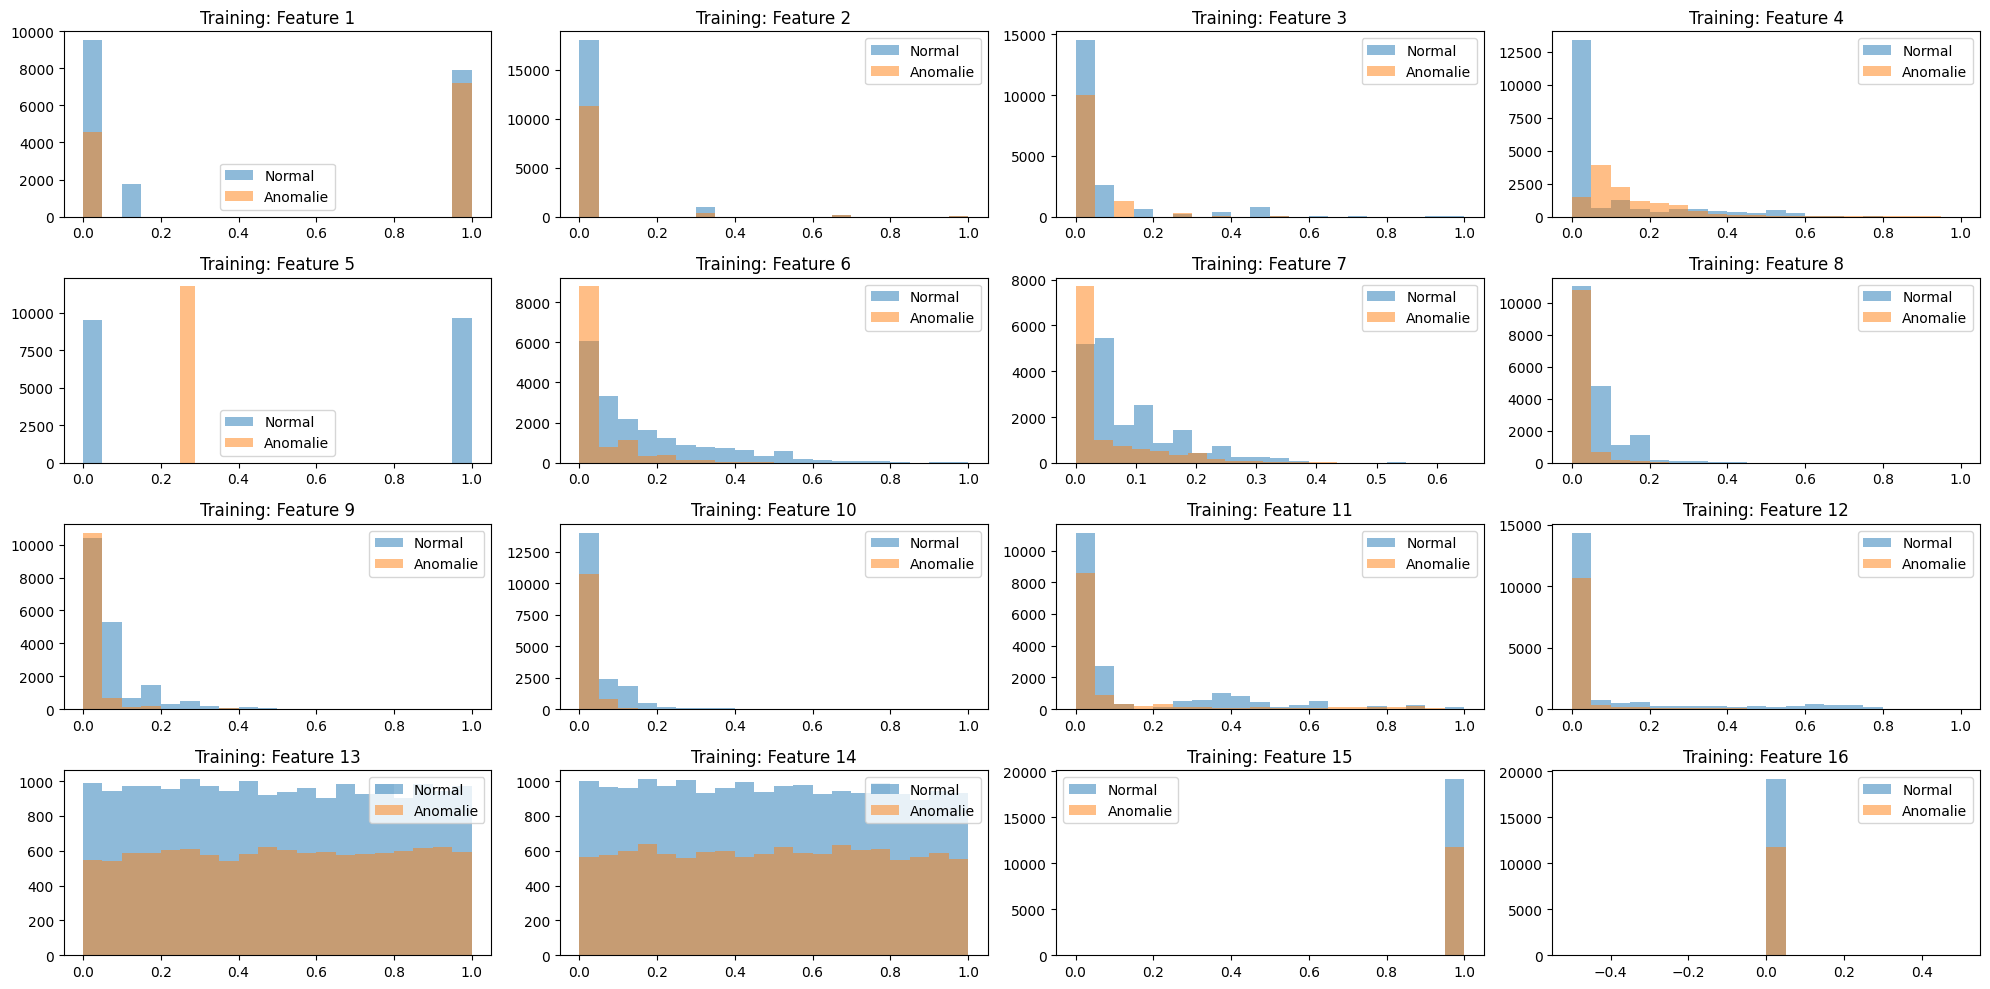

In [224]:
# Konvertiere TensorFlow-Konstanten in Pandas DataFrames
normal_train_data_df = pd.DataFrame(data=train_data.numpy())
a_normal_train_data_df = pd.DataFrame(data=a_train_data.numpy())

# Plot für Trainingsdaten
plt.figure(figsize=(20, 10))
for i in range(16):  # Iteriere über die ersten 16 Spalten
    plt.subplot(4, 4, i + 1)  # 4 Zeilen, 4 Spalten
    plt.hist(normal_train_data_df.iloc[:, i], bins=20, alpha=0.5, label='Normal')
    plt.hist(a_normal_train_data_df.iloc[:, i], bins=20, alpha=0.5, label='Anomalie')
    plt.title(f'Training: Feature {i + 1}')
    plt.legend()

plt.tight_layout()
plt.show()

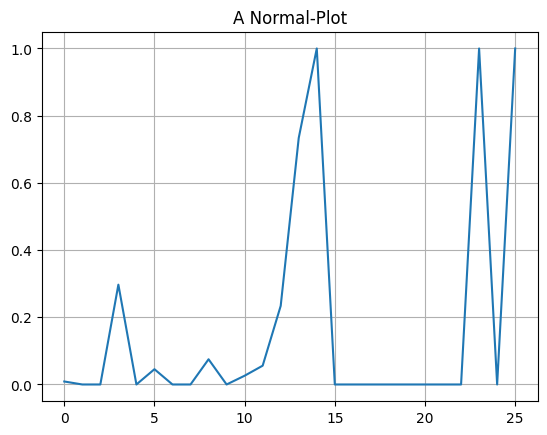

In [225]:
plt.grid()
plt.plot(np.arange(NUMBER_OF_CLASSES), train_data[0])
plt.title("A Normal-Plot")
plt.show()

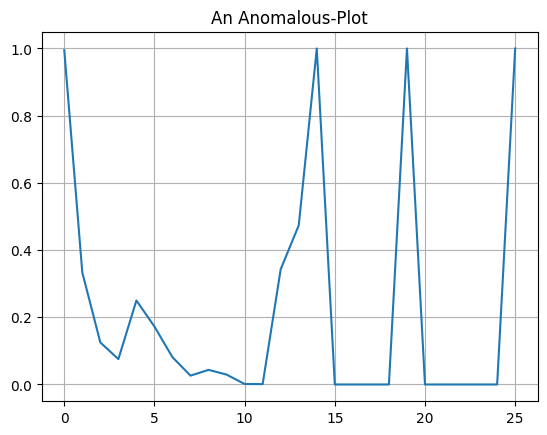

In [226]:
plt.grid()
plt.plot(np.arange(NUMBER_OF_CLASSES), a_train_data[0])
plt.title("An Anomalous-Plot")
plt.show()

# 3. Train the model

In [227]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(NUMBER_OF_CLASSES, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [228]:
autoencoder.compile(optimizer='adam', loss='mae')

In [229]:
history = autoencoder.fit(train_data, train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20


38/38 [==============================] - 1s 7ms/step - loss: 0.4033 - val_loss: 0.2942
Epoch 2/20
38/38 [==============================] - 0s 4ms/step - loss: 0.1706 - val_loss: 0.1087
Epoch 3/20
38/38 [==============================] - 0s 4ms/step - loss: 0.1051 - val_loss: 0.1039
Epoch 4/20
38/38 [==============================] - 0s 4ms/step - loss: 0.1028 - val_loss: 0.1019
Epoch 5/20
38/38 [==============================] - 0s 3ms/step - loss: 0.0994 - val_loss: 0.0961
Epoch 6/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0909 - val_loss: 0.0869
Epoch 7/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0838 - val_loss: 0.0802
Epoch 8/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0757 - val_loss: 0.0672
Epoch 9/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0626 - val_loss: 0.0604
Epoch 10/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0594 - val_loss: 0.0590
Epoch 11/20
38/38 [===========

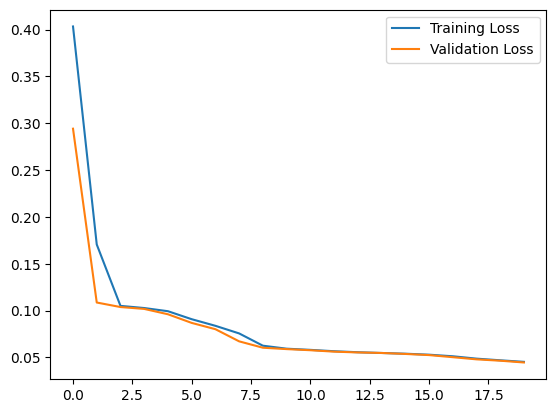

In [230]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

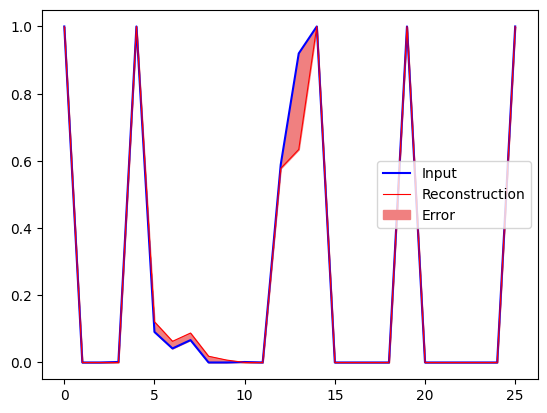

In [241]:
encoded_data = autoencoder.encoder(test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(test_data[0], 'b')
plt.plot(decoded_data[0], 'r', linewidth=0.8)
plt.fill_between(np.arange(NUMBER_OF_CLASSES), decoded_data[0], test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

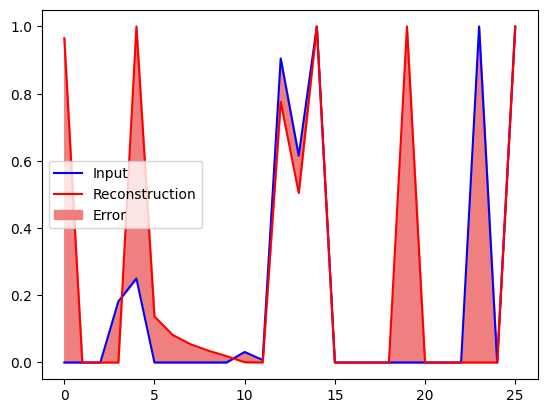

In [232]:
encoded_data = autoencoder.encoder(a_train_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(a_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(NUMBER_OF_CLASSES), decoded_data[0], a_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# 4. Implement Anomaly detection

600/600 [==============================] - 1s 1ms/step


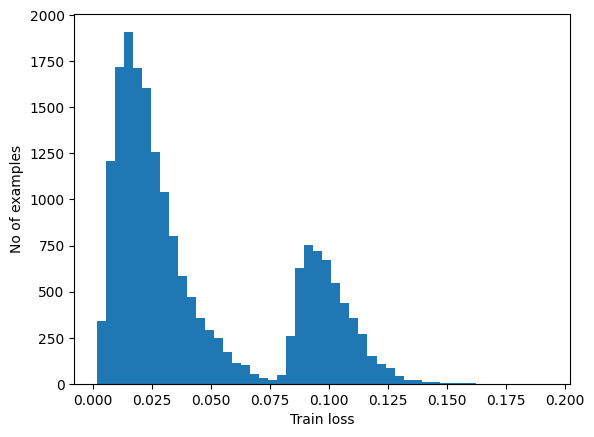

In [233]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [234]:
threshold= (np.mean(train_loss) + np.std(train_loss))
print("Threshold: ", threshold)

Threshold:  0.08067286


 1/92 [..............................] - ETA: 1s

92/92 [==============================] - 0s 1ms/step


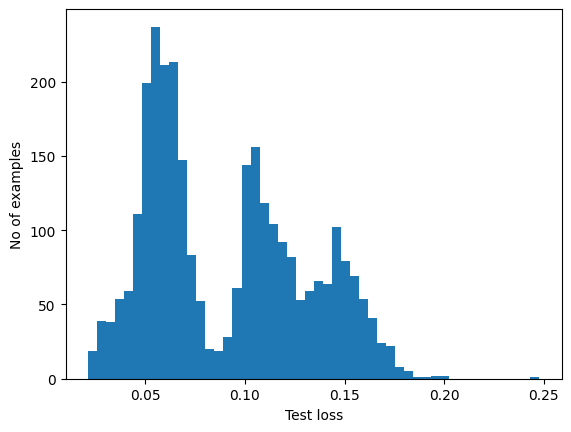

In [235]:
reconstructions = autoencoder.predict(a_test_data)
test_loss = tf.keras.losses.mae(reconstructions, a_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [236]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [239]:
preds = predict(autoencoder, a_test_data, threshold)
print_stats(preds, a_test_labels)

Accuracy = 0.4974481116025859
Precision = 1.0
Recall = 0.4974481116025859
